# Assignment 02b - (*MP only*) 3D Pedestrian Detection based on Multiple Sensors


## Goals
The goal of this assignment is the same as in 02a, i.e., obtaining **pedestrian locations in the 3D world (camera reference frame)** on the dataset sequence, but this time you should present a solution which aims to take advantage of **multiple sensors**, i.e. any combination of {camera, radar, LiDAR}.


Your approach should work in the following conditions:
- minimum distance of pedestrian to camera: 5 m
- maximum distance of pedestrian to camera: 40 m
- minimum pedestrian height: 1.2 m
- maximum pedestrian height: 1.9 m

## Input
You will work with the custom Sequence of `Dataset` with `start_index=1430` and `end_index=1545`.

Some functions you implemented in notebook `fa_02a_3d_pedestrian_detection_single_camera` will be reused in this notebook, so please make sure you finished notebook `fa_02a_3d_pedestrian_detection_single_camera` beforehand.

## Output
- Plots, visualizations and videos within this notebook
- Answers to the questions within this notebook
- Evaluation metrics and plots representing the performance of your approach

### Q 02b.1 Specification of intended solution
In this notebook, you have all available sensors to your disposal.

Please describe what you will implement to achieve the goal of obtaining 3D pedestrian locations using multiple sensors.
Here are some questions to stimulate the specification of your solution:
1. What processing steps and building blocks are needed?
2. Which concepts from the lectures are you planning to incorporate?
3. Which building blocks from the practica and the assignment notebooks before will you be re-using?
4. Which intermediate results can you represent in plots/visualizations/tables to show the graders that your intended solution does the right thing?

### A 02b.1
**Your answer:** (maximum 400 words)
1. The implementation will exist of three main building blocks which consist of some subblocks (functions that will be used). The first building block consists of detecting a person in the camera frame. Correct thresholds have to be chosen to ensure all humans will be detected but without too many outliers. The second buidling block consists of using the detection to find a ray in order to determine the depth of the person like in practicum 1. However, since the lidar data is known, the closest lidar point to the line is a human. These two given are used to find the location of the pedestrian, and using the intermediate results it is possible to verify the locations. The corresponding lidar point is used in the third building block, namely creating the dictionary.
2. The concepts of the lecture about 3D machine vision will be used. The intrinsic and extrinsic transformation will be used to create a 3D frame out of the 2D image. Besides the transformations, the theory about the perspective camera model and the transformations between frames have to be used in order to transform the lidar to the camera frame for example.
3. I will be reusing the same detection function as in 2a, the ground plane principles of practicum 1a and the function to create the dictionary.
4. First of all, the detection of the pedestrian in a frame. Only when that is correct it is convenient to continue. After that, the ray will be used to find an intersection with the lidar points. It is also a good idea to plot the ray and the closest point of the lidar in order to check if the transformation between frames went correctly. Moreover it is convenient to give an overview in a plot of the lidar points, the ground points that will be segmented and the points that lie within the scope of the camera frame. Lastly, a 3D plot of the dictionary will be provided to see the results before running it over the whole sequence.

### Q 02b.2 Proactive reflection
1. Which assumptions does your intended solution make?
2. In which situations might your intended solution fail?
3. In which situations is the multi-sensor solution better than the camera-only solution?

### A 02b.2
**Your answer:** (maximum 400 words)
1. The solution makes use of some assumptions. The first assumption made when detection the pedestrians, namely the shape of the bounding box. As could be seen in the practicum, the bounding box shouldn't be too large but also not too small to fit the pedestrians in. Therefore a shape of 200x100 has been used. The second assumption is that the middle of the detection in the bounding box always contains human. This assumption has been made for the ray to find the closest lidar point. When the closest point has been found, the location of the pedestrian could be determined. This is however the middel of the bounding box. Another assumption is that detected humans always stand on the ground, so the bounding box could be placed on the ground plane. 
2. The solution might fail when the used ray in order to determine the closest lidar point is actually a point very far beyond or in front of the human. Although the detection of the human on the camera image is correct, the methods fails to project the location of the pedestrian in 3D.  
3. The solution is much better in a way that you do not depend on only one sensor. With multiple sensors it is possible to use the findings of the one sensor and check the conclusions you made with the other sensor to make an even more accurate estimation of the location of the pedestrian. The difference could be shown by means of the assignment with mono-camera, where only the ground plane and the ray are used to determine the depth of the image. With multi-sensor it is possible to use the info received from the mono-camera and combine it with the lidar data to determine a more precise location of the pedestrian.

# now: HAVE FUN & HAPPY CODING!

In [1]:
# some magic to ease iterative implementation
from IPython import get_ipython

ipython = get_ipython()
if ipython:
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

If you run into any errors, please make sure that you don't have variable names in the to-be-imported notebooks which consist of pure capital letters (such as `T`, or `XYZ`, but also `P2`).
See [ipynb docs](https://ipynb.readthedocs.io/en/stable/#import-only-definitions).

## Your own PedestrianDetector
Now it's time to create another subclass of `PedestrianDetector` and detect pedestrians in 3D in the camera frame using **multiple sensors**.
Please provide visualizations of a few intermediate steps in order to obtain partial credit for concepts/implementation and to show the graders that your approach provides the intended functionality.

We recommend to start with a simple approach and iteratively improve it based on the experience you gain along the line.



In [2]:
### Importing some packages

import numpy as np
import cv2
import k3d
import matplotlib.pyplot as plt
from common.k3d_helpers import plot_axes, plot_box
import numpy as np
from assignment.solution_helpers import DebugOutputAggregator
from common.sequence_loader import Measurements
from preprocessing_fns import preprocessing_fn_mobilenet
from image_processing import generate_sequence_proposals
from tensorflow.image import non_max_suppression
from copy import copy
from common.visualization import draw_bbox_to_image
from tqdm.notebook import tqdm
from visualization import showimage
import open3d 
import tensorflow as tf
from matplotlib.tri import Triangulation

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Create your subclass if PedestrianDetector here
# Then instantiate it to an object called `pedestrian_detector`
# and feed it with a single measurement of the provided sequence
from ipynb.fs.defs.practicum3_mp import compute_3D_from_disparity
from ipynb.fs.defs.fa_02a_3d_pedestrian_detection_single_camera import PedestrianDetector
from ipynb.fs.defs.practicum3_mp import plot_point_clouds
from ipynb.fs.defs.fa_01a_data_visualization import get_plane_meshgrid
from common.sequence_loader import Dataset

patch_classifier = tf.keras.models.load_model('pedestrian_classifier')

# try to delete the current instance of pedestrian_detector to avoid running into memory issues
# while programming iteratively within this notebook
# use try-except as pedestrian_detector does not exist during the first call of this cell
try:
    del pedestrian_detector
except NameError:
    pass

is_debug = True

# YOUR CODE HERE
class MySecondFancyPedestrianDetector(PedestrianDetector):
    
    def __init__(self, is_debug):
        ### propagate is_debug flag to mama.
        super().__init__(is_debug)
        self.proposal_bboxes = [(200, 100)] 
        self.proposal_bboxes = np.asarray(self.proposal_bboxes)
        
        ### boundaries for ground plane
        self.x_min = -20.0
        self.x_max = 20.0
        self.y_min = 0
        self.y_max = 10
        self.x_step = 0.5
        self.y_step = 1
        
    def detect_draw(self, image_cam):
        """
        This function uses porposal boxes like in practicum 1 to find pedestrians in a given image.
        The bounding box and the image with the detected pedestrians are used in the functions to
        find the location of the pedestrian in 3D.
        """
        ### All code in this function is retrieved from practicum1 and modified
        ### Retrieve the camera image and only use the bottom of the image for processing
        image_gray = np.asarray([cv2.cvtColor(image_cam, cv2.COLOR_BGR2GRAY)])
        
        sequence_proposals = generate_sequence_proposals(image_gray, self.proposal_bboxes)
        print(f'Number of region proposals per frame: {sequence_proposals.shape[1]}')
        
        ### For every frame in the image, predict if pedestrian
        for frame in tqdm(sequence_proposals):
            frame_patches = np.concatenate([preprocessing_fn_mobilenet(proposal_patch.image) for proposal_patch in frame], 0)
            predictions = patch_classifier.predict(frame_patches)
            
            ### for every frame i, set the score pred (which is the ith prediction)
            for i, pred in enumerate(predictions):
                frame[i].score = pred   # Frame contains the prediction score and everything in the for loop
        
        ### Confidence threshold for pedestrians
        discrimination_threshold = 0.7
        ### For every frame of all patches in the sequence, check if the score is higher then the threshold 
        pedestrian_patches = [[proposal_patch for proposal_patch in frame if proposal_patch.score >= discrimination_threshold] for frame in tqdm(sequence_proposals)]
        
        nms_patches = []
        overlap_thresh = 0.1
        for frame in pedestrian_patches:
            all_bboxes = np.asarray([patch.bbox.get_bbox_corners() for patch in frame])
            confidences = np.asarray([patch.score[0] for patch in frame])
            if len(all_bboxes) > 0:
                idx = non_max_suppression(all_bboxes, confidences, max_output_size=len(all_bboxes), iou_threshold=overlap_thresh)
                nms_patches.append([frame[i] for i in idx])
            else:
                nms_patches.append([])

        frame_patch = nms_patches[0]
        
        return frame_patch
    
    def compute_3D_from_disparity(self, frame_patch_left, frame_patch_right):
        """
        This function is not used but was another implementation to find pedestrian locations.

        The performance of this method was worse than the ray method. This method makes use of disparity
        and the stereo camera. After using both methods, this method was decided not to use. 
        """
        XYZs = []
        disparity = measurements.get_disparity()
        print(disparity.max())
        right_projection_matrix = measurements.get_right_camera_projection_matrix()
        height, width = disparity.shape
        
        for i in range(len(frame_patch_left)):
            ### Bounding box for left camera
            bbox_x_left = frame_patch_left[i].bbox.u + 0.5*frame_patch_left[i].bbox.w
            bbox_y_left = frame_patch_left[i].bbox.v + 0.5*frame_patch_left[i].bbox.h
            center_bottom_bbox_left = [bbox_x_left, bbox_y_left, 1] ### make homogeneous 
            
            ### Bounding box for right camera
            bbox_x_right = frame_patch_right[i].bbox.u + 0.5*frame_patch_right[i].bbox.w
            bbox_y_right = frame_patch_right[i].bbox.v + 0.5*frame_patch_right[i].bbox.h
            center_bottom_bbox_right = [bbox_x_right, bbox_y_right, 1] ### make homogeneous 
            
            d = bbox_x_left - bbox_x_right
#             B = -right_projection_matrix[0, 0] / right_projection_matrix[0, -1] 
            B = right_projection_matrix[0,3]
            fx = right_projection_matrix[0,0]
            fy = right_projection_matrix[1,1]
            
            Z = -fx*B/(1000*d)
            X = Z*(bbox_x_left-width/2)/(fx)
            Y = Z*(bbox_y_left-height/2)/(fy)
            XYZ = [X, Y, Z]
            XYZs.append(XYZ)
        print(XYZs)
        return XYZs
    
    def distance_ray_point(self, vector, point):
        """
        This function calculated the perpendicular distance between a point and a line.
        The function is used to find the closest point to the ray.
        """
        ray = [0 - point[0], 0 - point[1], 0 - point[2]]
        cross_product = np.cross(ray, vector)
        cross_distance = np.sqrt(cross_product[0]**2 + cross_product[1]**2 + cross_product[2]**2) 
        vector_distance = np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)
        return cross_distance / vector_distance
    
    def segment_ground(self, pc_lidar_cam):
        """
        This function segments the ground so only relevant lidar points are used. The computation time
        decreases from an average of 10 seconds to 3-4 seconds.
        """
        a, b, c, d = self.measurements.get_ground_plane()
        ### All irrelevant lidar points under the ground plane+0.5 meters. 
        pc_lidar_noground = pc_lidar_cam[pc_lidar_cam[:,2] > (-(a*pc_lidar_cam[:,0] + b*pc_lidar_cam[:,1] + d)/c) + 0.5]
        return pc_lidar_noground

    def find_intersection(self, frame_patch):
        
        projection_matrix = self.measurements.get_camera_projection_matrix()[:,0:3]
        inverse_projection_matrix = np.linalg.inv(projection_matrix)
        
        pc_lidar = self.measurements.get_lidar_points()[:, 0:3]
        T_cam_lidar = self.measurements.get_T_camera_lidar()
           
        pc_lidar_homogeneous = np.vstack((pc_lidar.T, np.ones(len(pc_lidar))))
        pc_lidar_cam_right = (T_cam_lidar @ pc_lidar_homogeneous)[:-1, :].T
        
        pc_lidar_cam_left = pc_lidar_cam_right[pc_lidar_cam_right[:, 2] > -pc_lidar_cam_right[:, 0]]
        pc_lidar_cam = pc_lidar_cam_left[pc_lidar_cam_left[:, 2] > pc_lidar_cam_left[:, 0]]
        
        pc_lidar_noground = self.segment_ground(pc_lidar_cam)
        
        if self.is_debug:
                    plot = k3d.plot(camera_auto_fit=False, axes_helper=1.0)
                    plot += plot_axes(np.eye(4))
                    plot += k3d.points(positions=pc_lidar_cam, point_size=0.03, color=0x0000ff)                   
                    plot += k3d.points(positions=pc_lidar_noground, point_size=0.03, color=0xffff00)
               
        closest_lidar_points = []
        rays = []
        if len(frame_patch) > 0:
            for patch in frame_patch:
                bbox_x = patch.bbox.u + 0.5*patch.bbox.w
                bbox_y = patch.bbox.v + 0.5*patch.bbox.h
                center_bbox = [bbox_x, bbox_y, 1] ### make homogeneous 
                ray = inverse_projection_matrix @ center_bbox
                idx = 0
                closest_point = 1000000
                for i in range(len(pc_lidar_noground)):
                    point = [pc_lidar_noground[i, 0], pc_lidar_noground[i, 1], pc_lidar_noground[i, 2]]
                    distance = self.distance_ray_point(ray, point)
                    if distance < closest_point:
                        intersection = point
                        closest_point = distance
                        idx = i
                closest_lidar_points.append(pc_lidar_noground[idx])
                rays.append(ray)

                ### Plot the rays
                if self.is_debug:
                    plot += k3d.points(positions=pc_lidar_noground[idx], point_size=0.3, color=0x00ffff)
                    limits = np.linspace(0,40,100)
                    xr = ray[0]*limits
                    yr = ray[1]*limits
                    zr = ray[2]*limits
                    line = k3d.line(np.vstack([xr,yr,zr]).T, width=0.02, color=0x00ff00)
                    plot += line
        
        if self.is_debug:
            self.doa.add_k3d_plot(
                **{
                    "name": "lidar points, ray and closest point to pedestrian",
                    "description": "In the plot below the lidar points used for finding the intersection are displayed. "
                    "Only lidar points that are in the reach of the "
                    "camera are used. Also, only the points that are not the ground are taken into account. "
                    "By using only the relevant lidar points, the average run speed of the code decreases a lot. "
                    "In this plot the ground lidar points and the noground points are both shown in different colors. "
                    "The ray (like in ass. 02a) find its closest point to a point at the position of the pedestrian. "
                    "Is it barely possible that another point will be closer since the lidar can't reach behind an object. "
                    "The closest point is indicated as a light blue colored dot",
                    "plot": plot,
                }
            )
        return closest_lidar_points, rays
    
    def plot_3D_pedestrians(self, pedestrian_dicts):
        
        "Function to plot the 3D box which represents the pedestrian with the ray to show how the location"
        "has been determined."
        
        plot = k3d.plot(camera_auto_fit=False)
        plot.camera = [0.99, -7.18, -6.40, 0.19, -1.16, 4.17, -0.06, -0.89, 0.44]
        plot += plot_axes()  # camera frame
        
        ### Mesh
        ground_plane = self.measurements.get_ground_plane()
        X, Y, Z = get_plane_meshgrid(ground_plane, self.x_min, self.x_max, self.y_min, self.y_max, self.x_step, self.y_step)
        XYZ = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
        indices = Triangulation(X.ravel(), Y.ravel()).triangles.astype(np.uint32)
        plot += k3d.mesh(XYZ, indices, color_map=k3d.colormaps.basic_color_maps.CoolWarm,
                    attribute=Z, opacity=0.5)
        
        # origin frame of k3d plot is the camera fram, so use identity to transform labels
        T_origin_camera = np.eye(4)
        color_red = 0xFF0000
        if pedestrian_dicts:
            for pedestrian_dict in pedestrian_dicts:
                plot_box(plot, pedestrian_dict, T_origin_camera=T_origin_camera, color=color_red)

        self.doa.add_k3d_plot(
                **{
                    "name": "Pedestrian locations, ground plane and ray in a 3D plot.",
                    "description": "Below, a 3D plot with the locations of the pedestrians is shown. "
                    "Note that a rotation matrix around the x-axis has been used so the pedestrians are standing upwards. "
                    "A green ray has been displayed in order to show how the intersection with the ground "
                    "plane. The ground plane is displayed with an opacity of 0.5 so it is clearly visible where the pedestrians "
                    "are located. The plot shows the locations of the pedestrians on the ground plane.",
                    "plot": plot,
                }
            )
        return 
    
    def show_image_bbox(self, frame_patch):
        image = self.measurements.get_camera_image()
        if len(frame_patch) > 0:
            for i in range(len(frame_patch)):
                image = draw_bbox_to_image(image, frame_patch[i].bbox)
        
        ### Shows image of image with bounding box    
            self.doa.add_image(
                **{
                    "name": "Camera frame with detection",
                    "description": "This image shows the detection of the pedestrian with a green detection box "
                    "to check wether the detection has been done correctly by the classifier.",
                    "image": image,
                }
            )
            
    def plot_lidar_points(self):
        plot = k3d.plot(camera_auto_fit=False, axes_helper=1.0)
        plot += plot_axes(np.eye(4))
        pc_lidar = self.measurements.get_lidar_points()[:,:3]
        plot += k3d.points(positions=pc_lidar, point_size=0.03, color=0x0000ff)  
        self.doa.add_k3d_plot(
        **{
            "name": "All lidar points in a 3D plot",
            "description": "In the following plot, all lidar points are shown. It is clear that there are many "
            "irrelevant points such as behind the car that increase the speed of the code drastically. ",
            "plot": plot,
        }
    )
    
    def get_pedestrian_dicts(self):
        pedestrian_dicts = []
               
        image_cam_left = self.measurements.get_camera_image()
        image_cam_right = self.measurements.get_right_camera_image()
        frame_patch_left = self.detect_draw(image_cam_left)
        T_cam_lidar = self.measurements.get_T_camera_lidar()
        
        if self.is_debug:
            self.show_image_bbox(frame_patch_left)
            self.plot_lidar_points()
            
        closest_lidar_points, rays = self.find_intersection(frame_patch_left)
        a, b, c, d = self.measurements.get_ground_plane()
            
#         frame_patch_right = self.detect_draw(image_cam_right, show_bbox=False)
#         XYZs = self.compute_3D_from_disparity(frame_patch_left, frame_patch_right)
        
        if len(frame_patch_left) > 0:
            for i in range(len(closest_lidar_points)):
                pedestrian_dict = {}
                closest_lidar_point = closest_lidar_points[i]
                x_cam = closest_lidar_point[0]
                y_cam = (-(a*closest_lidar_point[0] + c*closest_lidar_point[2] + d)/b)
                z_cam = closest_lidar_point[2]
                cam = np.array([x_cam, y_cam, z_cam])
                ### Use rotation matrix around the x-axis using [[1,0,0],[0,cos(90),-sin(90)], [0,sin(90),cos(90)]] 
                ### is equal to np.eye(3)*np.array([[1,0,0],[0,0,-1],[0,1,0]]).
                if z_cam < 0:
                    z_cam = 0
                T_cam_object = np.eye(4)
                T_cam_object[:3,:3] = T_cam_lidar[:3, :3]
                T_cam_object[:3, 3] = cam.T
                pedestrian_dict["label_class"] = "Pedestrian"
                pedestrian_dict["extent_object"] = np.array([0.8, 0.8, 1.8])
                pedestrian_dict["T_cam_object"] = T_cam_object
                pedestrian_dict["score"] = frame_patch_left[0].score[0]
                pedestrian_dicts.append(pedestrian_dict)
        
        if self.is_debug:
            self.plot_3D_pedestrians(pedestrian_dicts)
         
        return pedestrian_dicts
        
dataset = Dataset()
start_index = 1430
end_index = 1545
sequence = dataset.get_custom_sequence(start_index, end_index)

pedestrian_detector = MySecondFancyPedestrianDetector(is_debug=is_debug)

# get first measurements object of the sequence
measurements = next(iter(sequence))

# feed measurements
pedestrian_detector.set_measurements(measurements)

pedestrian_dicts = pedestrian_detector.get_pedestrian_dicts()
pedestrian_dicts

Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\jobmu\anaconda3\envs\mp-iv\lib\site-packages\traittypes\traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


[{'label_class': 'Pedestrian',
  'extent_object': array([0.8, 0.8, 1.8]),
  'T_cam_object': array([[-7.98020046e-03, -9.99854088e-01,  1.51049001e-02,
           8.03792820e+00],
         [ 1.18496999e-01, -1.59444995e-02, -9.92826402e-01,
           3.03866560e+00],
         [ 9.92922425e-01, -6.13310002e-03,  1.18606903e-01,
           1.42715853e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]),
  'score': 0.972836}]

In [4]:
# make sure each pedestrian_dict has all required keys present
required_keys = {"label_class", "extent_object", "T_cam_object", "score"}
for pedestrian_dict in pedestrian_dicts:
    assert required_keys.issubset(set(pedestrian_dict.keys()))

In [5]:
# make sure the pedestrian_detector object is a (duck-typed) PedestrianDetector subclass
assert isinstance(pedestrian_dicts, list)
assert {"doa", "get_pedestrian_dicts"}.issubset(set(dir(pedestrian_detector)))


(image) Camera frame with detection:
This image shows the detection of the pedestrian with a green detection box to check wether the detection has been done correctly by the classifier.


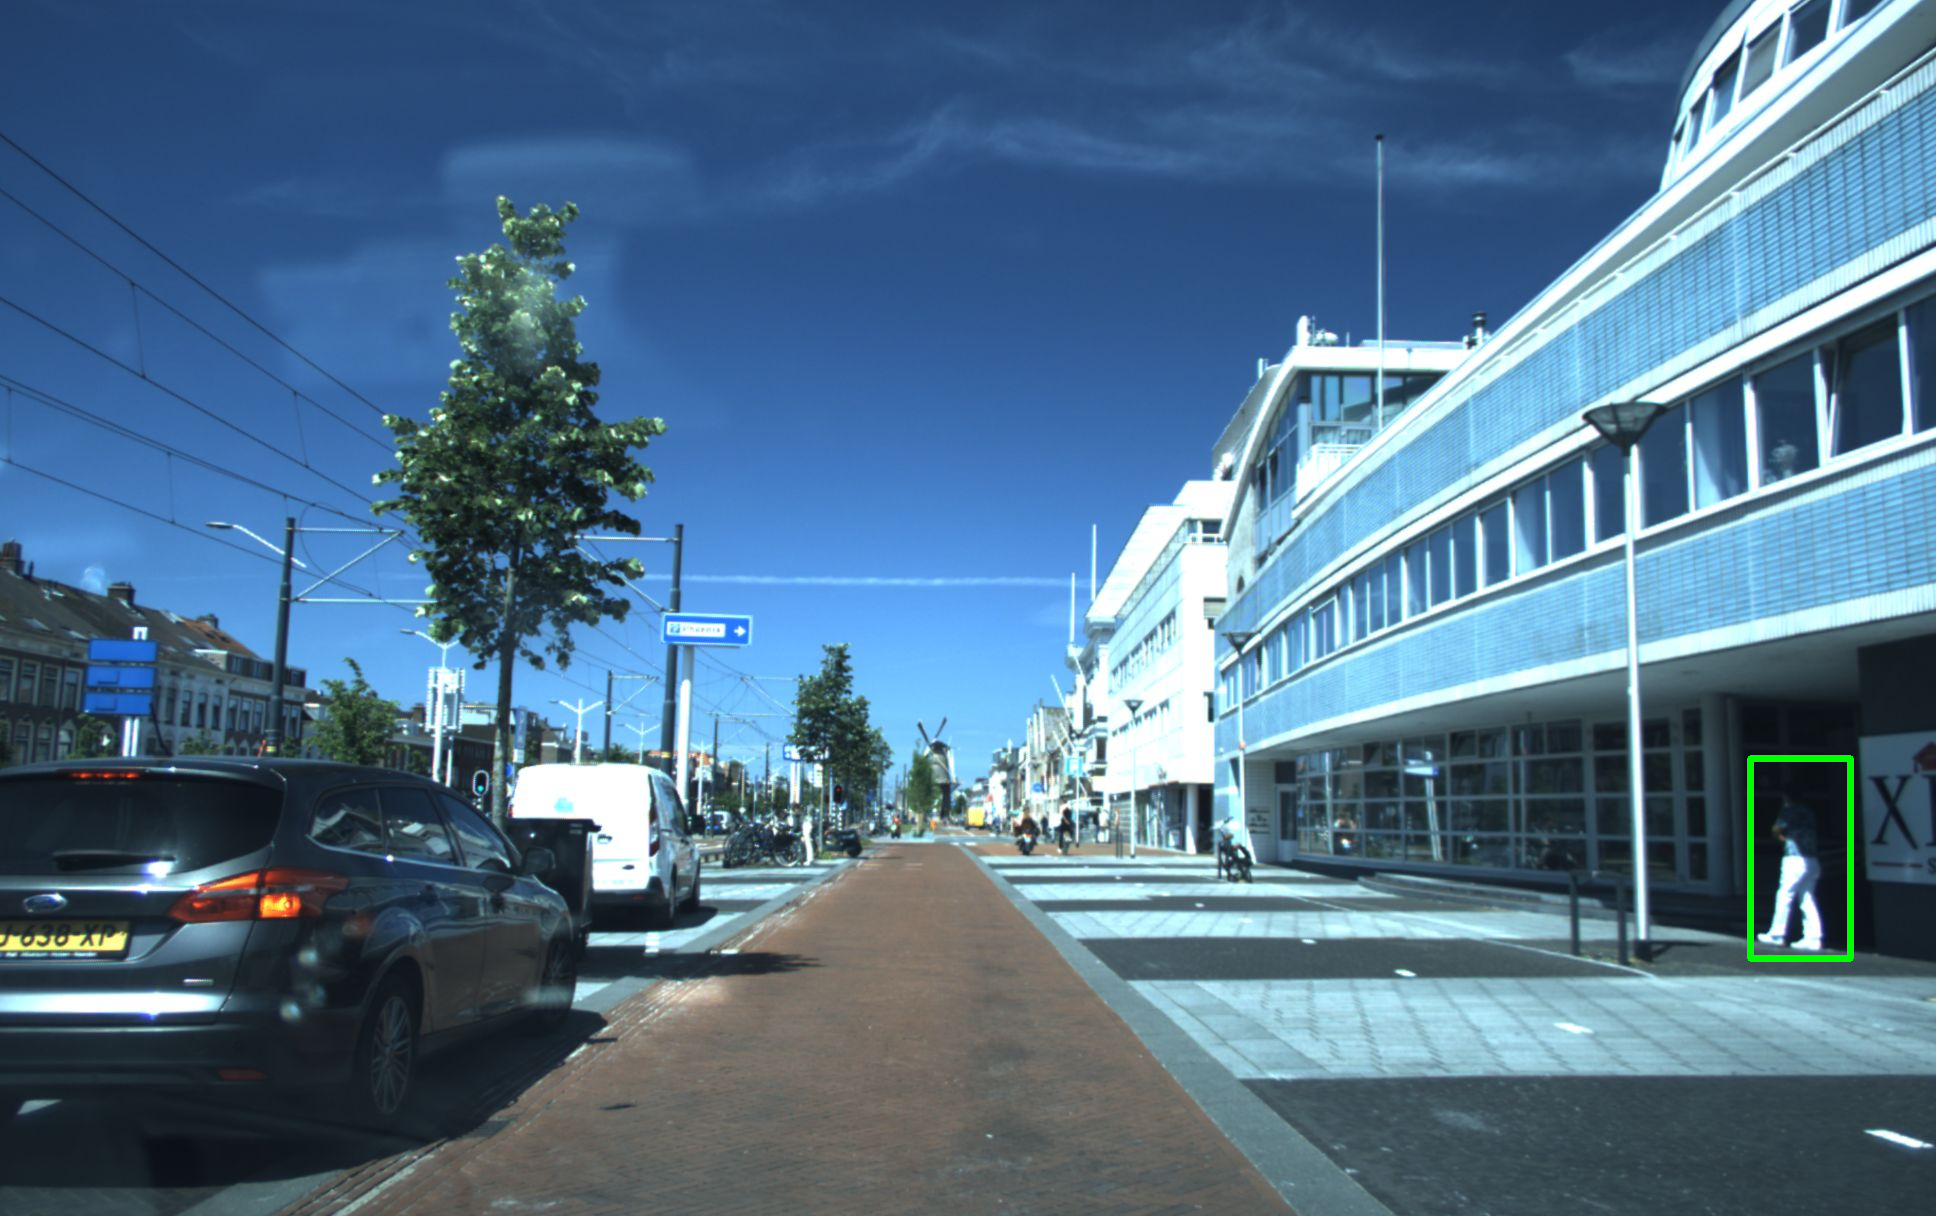


(k3d plot) All lidar points in a 3D plot:
In the following plot, all lidar points are shown. It is clear that there are many irrelevant points such as behind the car that increase the speed of the code drastically. 


Output()


(k3d plot) lidar points, ray and closest point to pedestrian:
In the plot below the lidar points used for finding the intersection are displayed. Only lidar points that are in the reach of the camera are used. Also, only the points that are not the ground are taken into account. By using only the relevant lidar points, the average run speed of the code decreases a lot. In this plot the ground lidar points and the noground points are both shown in different colors. The ray (like in ass. 02a) find its closest point to a point at the position of the pedestrian. Is it barely possible that another point will be closer since the lidar can't reach behind an object. The closest point is indicated as a light blue colored dot


Output()


(k3d plot) Pedestrian locations, ground plane and ray in a 3D plot.:
Below, a 3D plot with the locations of the pedestrians is shown. Note that a rotation matrix around the x-axis has been used so the pedestrians are standing upwards. A green ray has been displayed in order to show how the intersection with the ground plane. The ground plane is displayed with an opacity of 0.5 so it is clearly visible where the pedestrians are located. The plot shows the locations of the pedestrians on the ground plane.


Output()

[None, None, None, None]

In [6]:
# let's have a look at your debug outputs
# show debug outputs
#
# it is important to us, that you create sufficient intermediate results
# and also use verbose descriptions of the debug outputs
# (as you would use for captions of figures in scientific papers)
#
# you can toggle scrolling of the output by selecting this cell and 'Cell' > 'Current Outputs' > 'Toggle Scrolling'
[None for i in iter(pedestrian_detector.doa)]

### Localize pedestrians on the whole sequence

Please assemble the target structure `frame_pedestrian_dicts` below by iterating over the sequence and obtaining all pedestrian dicts.

In [7]:
from assignment.solution_helpers import DurationAggregator
from tqdm.notebook import tqdm

sequence = dataset.get_custom_sequence(start_index, end_index)
frame_pedestrian_dicts = {
    1430: [
        {
            # ...
        },
    ]  # frame_index as key. Fill me with pedestrian_dicts using your subclass of PedestrianDetector
}

is_debug = False
pedestrian_detector = MySecondFancyPedestrianDetector(is_debug=False)  # overwrite me with your instantiated pedestrian detector class

# YOUR CODE HERE
# raise NotImplementedError()

# log time for running detector on each measurements instance
duration_aggregator = DurationAggregator(is_print_durations=True)
for measurements in tqdm(duration_aggregator.aggregate_durations(sequence), total=len(sequence)):

    pedestrian_detector.set_measurements(measurements)
    refined_proposal_dicts_nms = pedestrian_detector.get_pedestrian_dicts()
    frame_pedestrian_dicts[measurements.get_index()] = refined_proposal_dicts_nms

  0%|          | 0/116 [00:00<?, ?it/s]

Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

000: 3.810 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

001: 3.708 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

002: 3.860 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

003: 3.655 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

004: 4.186 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

005: 2.699 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

006: 3.265 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

007: 3.854 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

008: 2.383 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

009: 2.951 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

010: 2.620 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

011: 2.591 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

012: 2.428 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

013: 2.533 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

014: 3.324 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

015: 3.111 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

016: 3.242 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

017: 2.388 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

018: 2.504 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

019: 2.575 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

020: 2.616 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

021: 2.478 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

022: 2.558 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

023: 3.501 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

024: 3.016 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

025: 3.064 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

026: 3.809 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

027: 3.298 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

028: 3.243 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

029: 3.348 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

030: 3.122 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

031: 4.728 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

032: 4.173 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

033: 3.551 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

034: 3.606 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

035: 2.368 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

036: 3.235 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

037: 2.944 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

038: 2.935 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

039: 3.097 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

040: 3.532 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

041: 5.894 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

042: 5.346 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

043: 4.538 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

044: 3.585 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

045: 3.657 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

046: 3.033 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

047: 4.022 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

048: 2.939 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

049: 4.177 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

050: 4.072 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

051: 3.589 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

052: 4.744 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

053: 4.287 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

054: 4.792 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

055: 3.249 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

056: 3.924 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

057: 3.910 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

058: 4.536 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

059: 4.167 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

060: 3.472 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

061: 3.590 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

062: 5.090 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

063: 5.008 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

064: 5.066 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

065: 4.422 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

066: 4.435 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

067: 4.708 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

068: 3.698 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

069: 3.555 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

070: 3.643 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

071: 3.550 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

072: 3.480 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

073: 3.604 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

074: 4.303 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

075: 4.089 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

076: 4.309 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

077: 4.248 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

078: 4.046 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

079: 4.250 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

080: 4.734 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

081: 4.731 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

082: 4.100 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

083: 4.293 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

084: 4.137 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

085: 4.475 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

086: 4.029 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

087: 3.998 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

088: 4.799 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

089: 4.072 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

090: 5.328 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

091: 4.166 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

092: 4.026 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

093: 3.301 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

094: 4.808 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

095: 5.754 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

096: 4.881 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

097: 3.467 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

098: 4.406 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

099: 5.005 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100: 4.436 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

101: 6.888 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

102: 4.389 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

103: 5.124 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

104: 5.503 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

105: 3.432 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

106: 4.600 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

107: 5.525 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

108: 4.537 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

109: 4.317 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

110: 3.934 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

111: 4.009 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

112: 3.958 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

113: 2.454 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

114: 4.213 s
Number of region proposals per frame: 1014


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

115: 3.534 s


In [8]:
assert len(duration_aggregator) == len(sequence)
mean_duration_s = duration_aggregator.get_mean_duration_s()
print(f"mean duration: {mean_duration_s:.2f} s")

mean duration: 3.88 s


### Q 02b.3 Runtime
Please reflect on the mean duration of your algorithm.
1. What is the mean duration of your duration on your machine?
2. How much speed-up would be needed in order to run it 'real-time' within a car given a sensor measurement update rate of 10 Hz?
3. How does the runtime compare against your camera-only detector?

Don't overoptimize: your approach should run at most 30 s per timestep (to keep our inference time during grading manageable), though somthing around 1-3 s per timestep seems a realistic goal.

### A 02b.3
**Your answer:** (maximum 150 words)
1. The mean duration on this machine equals 3.68 seconds. 
2. According to the university of Michican the reaction time of a self driving car at the moment is 0.5 seconds. In order to run the algorithm in real time should be 3.18 seconds faster than now. With 10 Hz that should be 31.8 times faster.
3. The camera-only detecter had a run time of 2.40 seconds. The difference is that this method also checks the lidar points and loops over the relevant ones. This loop causes the delay but provides a better localization of the pedestrian.

In [9]:
# check for proper format
from assignment.solution_helpers import save_frame_pedestrian_dicts

# make sure all frames within the sequence are filled with frame pedestrian dicts
assert set(frame_pedestrian_dicts.keys()) == set(sequence.get_indices())

# check for type of output
for fpds in frame_pedestrian_dicts.values():
    for fpd in fpds:
        assert {"label_class", "extent_object", "T_cam_object"}.issubset(set(fpd.keys()))
        assert fpd["T_cam_object"].shape == (4, 4)
        assert fpd["label_class"] == "Pedestrian"

# use save_frame_pedestrian_dicts with is_dry_run=True to check for serializability
is_serializable = True
try:
    save_frame_pedestrian_dicts(frame_pedestrian_dicts, is_dry_run=True)
except TypeError as e:
    print("Error, frame_pedestrian_dicts is not json serializable: %s" % str(e))
    is_serializable = False
if not is_serializable:
    assert False, "See error above"

## Quantitative Evaluation (Image Projections)
Please evaluate your detector via comparing the projected 2D bounding boxes of the `frame_pedestrian_dicts` you obtained via your approach against ground truth pedestrian bounding boxes (cf. [Practicum 1](../practicum1/practicum1.ipynb)).
Evaluation metrics will be ROC curves, average precision (IOU=0.2) and mean average precision (mAP).

### Ground Truth bounding boxes (image projections)
Let use compute `gt_bboxes` with a list of pedestrian bounding box coordinates for each frame by reusing our implementation from 02a.

In [10]:
from ipynb.fs.defs.fa_02a_3d_pedestrian_detection_single_camera import get_gt_bboxes

gt_bboxes = get_gt_bboxes(sequence)

In [11]:
assert len(gt_bboxes) == len(sequence)
assert all(len(bbox) == 4 for bboxes in gt_bboxes for bbox in bboxes)

### Prediction bounding boxes (image projections)
Let's assemble `sequence_proposals` out your `frame_pedestrian_dicts` as in 02a.

In [12]:
from ipynb.fs.defs.fa_02a_3d_pedestrian_detection_single_camera import get_sequence_proposals

sequence_proposals = get_sequence_proposals(sequence, frame_pedestrian_dicts)

In [13]:
from practicum1.ImagePatch import ImagePatch

assert len(sequence_proposals) == len(gt_bboxes)
# sequence_proposals should be of type ImagePatch and have score of proper shape and range
assert all(isinstance(sp, ImagePatch) for sps in sequence_proposals for sp in sps)
assert all(
    len(sp.score) == 1 for sps in sequence_proposals for sp in sps
), "score as in practicum1 needs to be a one-element list"
assert all(sp.score[0] >= 0.0 for sps in sequence_proposals for sp in sps)
assert all(sp.score[0] <= 1.0 for sps in sequence_proposals for sp in sps)

### Metrics Dict (image projections)
We use `generate_metrics_dict` as in Practicum 1 to evaluate `sequence_proposals` against `gt_bboxes` for the given `discrimination_thresholds` and `iou_thresholds`.

In [ ]:
from practicum1.evaluation import generate_metrics_dict

discrimination_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
iou_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

metrics_dict = generate_metrics_dict(sequence_proposals, gt_bboxes, discrimination_thresholds, iou_thresholds)

metrics_dict

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
assert set(metrics_dict.keys()) == set(iou_thresholds)
assert all(v.shape == (len(discrimination_thresholds), 2) for v in metrics_dict.values())

### Precision-Recall Curve (image projections)
Let's plot the Precision-Recall curve for the IOU threshold of 0.2 (and interactively).
See Practicum 1.

In [ ]:
# insert a precision-recall curve plot here
from ipynb.fs.defs.practicum1 import plot_pr_curve
from ipywidgets import fixed, interact, FloatSlider

interact(plot_pr_curve, metrics_dict=fixed(metrics_dict), iou_thresh=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.2))

### Average Precision (image projections)
What is the `average_precision` for `iou_threshold = 0.2`?
Feel free to copy your code from 02a.


In [ ]:
iou_threshold = 0.2

from sklearn.metrics import auc

precisions, recalls = metrics_dict[iou_threshold].T
average_precision = auc(recalls, precisions)

print(f"Average Precision @ IoU thresh. of {iou_threshold:.01f} = {average_precision * 100:.01f} (image projections)")

In [ ]:
assert average_precision >= 0.0
assert average_precision <= 1.0

### Mean Average Precision (image projections)
What is the `mean_average_precision` (mAP) of your approach?

A basic implementation should achieve an mAP value of at least 5%.

In [ ]:
from practicum1.metrics import mAP

mean_average_precision = mAP(metrics_dict)
print(f"Mean Average Precision: {mean_average_precision * 100:.01f} (image projections)")

In [ ]:
# DO NOT DELETE THIS CELL!

## Video (qualitative evaluation)
Let's create a video over the whole sequence drawing the projected bounding boxes of all detected 3D pedestrians in `frame_pedestrian_dicts`.
We reuse the function `draw_pedestrian_bounding_boxes` we implemented in `fa_02b`.

In [ ]:
from ipynb.fs.defs.fa_02a_3d_pedestrian_detection_single_camera import draw_pedestrian_bounding_boxes

images_draw = draw_pedestrian_bounding_boxes(frame_pedestrian_dicts, sequence)

In [ ]:
# make sure we have a video along the whole sequence
assert len(images_draw) == len(sequence)
# make sure we have images of full resolution and color
assert images_draw[0].shape == (1216, 1936, 3)

Let's visualize the video inline via `create_animation`. This might take a minute.

In [ ]:
from common.visualization import create_animation
from IPython.core.display import HTML

anim = create_animation(images_draw)
HTML(anim.to_html5_video())

# Birds-eye view visualization

Let's create a birds-eye view plot to judge the distance of the objects to the camera frame.

In [ ]:
# extract pedestrian positions in birds-eye view for every frame_index from frame_pedestrian_dicts
import numpy as np
from collections import defaultdict

frame_ped_positions = dict()
frame_ped_scores = dict()
for frame_index, pedestrian_dicts in frame_pedestrian_dicts.items():
    frame_ped_positions[frame_index] = []
    frame_ped_scores[frame_index] = []
    for pedestrian_dict in pedestrian_dicts:
        ped_position = pedestrian_dict["T_cam_object"][[0, 2], 3]  # take only xz positions (in camera frame)
        frame_ped_positions[frame_index].append(ped_position)
        frame_ped_scores[frame_index].append(pedestrian_dict["score"])
for frame_index, ped_positions in frame_ped_positions.items():
    frame_ped_positions[frame_index] = np.asarray(ped_positions).reshape(-1, 2)
for frame_index, ped_scores in frame_ped_scores.items():
    frame_ped_scores[frame_index] = np.asarray(ped_scores).reshape(-1, 1)
frame_ped_positions[1430], frame_ped_scores[1430]  # frame 1430

In [ ]:
# do the same for ground truth pedestrian positions
frame_ped_gts = dict()
for measurements in sequence:
    frame_index = measurements.get_index()
    frame_ped_gts[frame_index] = []
    # subselect pedestrians
    labels_camera = [m for m in measurements.get_labels_camera() if m["label_class"] == "Pedestrian"]
    for label_camera in labels_camera:
        ped_gt = label_camera["T_cam_object"][[0, 2], 3]  # take only xz positions (in camera frame)
        frame_ped_gts[frame_index].append(ped_gt)
for frame_index, ped_gts in frame_ped_gts.items():
    frame_ped_gts[frame_index] = np.asarray(ped_gts)
frame_ped_gts[1430]  # frame 1430

In [ ]:
# create interactive plot showing detected pedestrian positions and ground truth positions
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# get bounds for plotting
all_ped_positions = np.vstack(list(frame_ped_positions.values()))
all_ped_gts = np.vstack(list(frame_ped_gts.values()))
all_peds = np.vstack([all_ped_positions, all_ped_gts])
xmax, zmax = np.max(np.abs(all_peds), axis=0)  # symmetric
xmin, zmin = -xmax, -zmax
zmin = 0.0  # make plot start at camera position

fig, ax = plt.subplots(figsize=(15, 12))

def plot_ped_positions(frame_index):
    ax.cla()  # remove content from last frame
    ax.set_xlim(left=xmin - 2.0, right=xmax + 2.0)
    ax.set_ylim(bottom=zmin, top=zmax + 2.0)
    ax.set_aspect("equal")
    ax.set_xlabel("x (camera frame)")
    ax.set_ylabel("z (camera frame)")
    ax.set_title(f"frame: {frame_index}")
    ax.grid(True, alpha=0.5)
    ax.scatter(0.0, 0.0, color="r")  # camera frame

    if frame_ped_gts[frame_index].size > 0:
        ax.scatter(
            frame_ped_gts[frame_index][:, 0], frame_ped_gts[frame_index][:, 1], color="y", s=500, marker="*", alpha=0.6
        )

    if frame_ped_positions[frame_index].size > 0:
        ax.scatter(frame_ped_positions[frame_index][:, 0], frame_ped_positions[frame_index][:, 1])


ani = FuncAnimation(fig, func=plot_ped_positions, frames=list(frame_ped_positions.keys()))
plt.close()  # avoid drawing additional figure below animation
HTML(ani.to_jshtml())

## Quantitative Evaluation (birds-eye view)

Let's see what average precision (AP) and mean average precision (mAP) we get for the birds-eye view based evaluation, as was done in the notebook pedestrian detection with a _single camera_.

In [ ]:
# create sequence ground plane proposals
# ground plane == XZ plane of camera frame
from assignment.evaluation_helpers import get_sequence_proposals_circle

sequence_groundplane_proposals = get_sequence_proposals_circle(frame_ped_positions, frame_ped_scores)

print('The sequence_groundplane_proposals has for every frame a list with a dict for every detection!')
print('The list for the first frame is:\n{}'.format(sequence_groundplane_proposals[0]))

In [ ]:
# create ground truth sequence ground plane proposals
# ground plane == XZ plane of camera frame
from assignment.evaluation_helpers import get_GT_sequence_groundplane_proposals

GT_sequence_groundplane_proposals = get_GT_sequence_groundplane_proposals(frame_ped_gts)
    
print('The GTsequence_groundplane_proposals has for every frame a list with a dict for every pedestrian!')
print('The list for the first frame is:\n{}'.format(GT_sequence_groundplane_proposals[0]))

In [ ]:
from assignment.evaluation_helpers import generate_metrics_dict_circle

discrimination_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
iou_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
radius_m = 3.0  # radius of representing circles for overlap computation

# generate the metrics_dict from birds-eye view based circles
metrics_dict = generate_metrics_dict_circle(sequence_groundplane_proposals,
                                            GT_sequence_groundplane_proposals,
                                            discrimination_thresholds,
                                            iou_thresholds,
                                            radius=radius_m)

### Precision-Recall Curve (birds-eye view)
Run the cell below to plot the Precision-Recall curve for the IoU threshold of 0.2 (and interactively).
See Practicum 1 and the notebook pedestrian detection with a _single camera_.

In [ ]:
# plot the precision-recall curve
interact(plot_pr_curve, metrics_dict=fixed(metrics_dict), iou_thresh=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.2))

### Average Precision (birds-eye view)
What is the `average_precision` for `iou_threshold = 0.2`?


In [ ]:
from sklearn.metrics import auc

iou_threshold = 0.2
precisions, recalls = metrics_dict[iou_threshold].T
average_precision = auc(recalls, precisions)

print(f"Average Precision @ IoU thresh. of {iou_threshold:.01f} = {average_precision * 100:.01f} (birds-eye view)")

### Mean Average Precision (birds-eye view)
What is the `mean_average_precision` (mAP) of your approach?
Let's reuse code from Practicum 1.

A basic implementation should achieve an mAP value of at least 10%.

In [ ]:
from practicum1.metrics import mAP

mAP_value = mAP(metrics_dict)

print(f'Mean Average Precision: {mAP_value*100:.01f} (birds-eye-view)')

### Q 02b.4 Interpretation of experimental results
Please interpret your experimental results:
1. Qualitative: How does your approach behave in terms of false positives and false negatives? (video / birds-eye view plot)
2. Quantitative: Please discuss the Precision-Recall plot, AP and mAP values in comparison to ideally achievable values. Compare the obtained 3D detection performance and associated runtime (this notebook), with the numbers obtained in the single-camera case (previous notebook).

### A 02b.4
**Your answer:** (maximum 350 words)
1. What could be observed from the video and the bird eye view is that the approach almost has no false negatives. The pedestrians that appear in the video are detected correctly and even more stable than the detector from assignment 02a since the lidar points confirm the location of the pedestrian.
2. The precision recall curve for this approach is better than the one of assignment 2. First of all the mean average precision is much higher, which is good. Comparing the curves show us how this is possible. For the bird eye view, the PR curve remains the same for low values and only from 0.9 big changes are visible. Also the detector PR has high precision for values till 0.7, just from there it decreases a lot. This means that the approach is suitable for more thresholds and so for more situations. This is the reason that also outliers are less present. 

The `frame_pedestrian_dicts` will not be used in successive notebooks.
If you need pedestrian positions in further notebooks, please use the serialized output of the camera-only solution.
Let's still check for data completeness in the next cell.

In [ ]:
from assignment.solution_helpers import save_frame_pedestrian_dicts

# check for serializability (despite not writing out)
save_frame_pedestrian_dicts(frame_pedestrian_dicts, is_dry_run=True)

### Q 02b.5 Future Work
1. How can improve your method even more, i.e., if you had more time at your disposal?

### A 02b.5
**Your answer:** (maximum 150 words)
1. If I had more time it could be wise to see if using a better classifier is beneficial, or to improve the classifier even more. This could lead to a better precision/recall. Something that could also be improved is the way of detecting the pedestrians on the patch. The sliding window proposal is not the best way to do it, a 'smart' proposal like in practicum 1 would perform much better (same as ass. 02a). In this assignment I could additionally make use of different methods and check wether it improves the localization of the pedestrian. Now I used one camera and lidar points, but it could be beneficial to take into account lidar points, radar points and both the camera images. These combined could make a strong localizer from three different weak ones and improve the approach. 

# GREAT JOB!
You've come very far. You detected pedestrian locations in 3D around a moving vehicle from noisy sensor data of multiple sensors.
That's a great achievement.